In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import time
import math
import numpy as np

In [3]:
from samplers import MWGSampler
from proposals import RWMHProposal 

# Define model

In [4]:
from dcpyps.samples import samples
from dcpyps import dataset, mechanism

##### Data

In [5]:
fname = "CH82.scn" # binary SCN file containing simulated idealised single-channel open/shut intervals
tr = 1e-4 # temporal resolution to be imposed to the record
tc = 4e-3 # critical time interval to cut the record into bursts
conc = 100e-9 # agonist concentration 
# Initaialise SCRecord instance.
rec = dataset.SCRecord([fname], conc, tres=tr, tcrit=tc)
rec.printout()



 Data loaded from file: CH82.scn
Concentration of agonist = 0.100 microMolar
Resolution for HJC calculations = 100.0 microseconds
Critical gap length to define end of group (tcrit) = 4.000 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 1672
Number of resolved periods = 1672

Number of open periods = 836
Mean and SD of open periods = 5.703315580 +/- 6.217026586 ms
Range of open periods from 0.101663936 ms to 36.745440215 ms

Number of shut intervals = 836
Mean and SD of shut periods = 2843.529462814 +/- 3982.407808304 ms
Range of shut periods from 0.100163714 ms to 30754.167556763 ms
Last shut period = 3821.345090866 ms

Number of bursts = 572
Average length = 8.425049759 ms
Range: 0.102 to 62.906 millisec
Average number of openings= 1.461538462


##### Mechanism

In [6]:
mec = samples.CH82()
# PREPARE RATE CONSTANTS.
# Fixed rates
mec.Rates[7].fixed = True
# Constrained rates
mec.Rates[5].is_constrained = True
mec.Rates[5].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[5].constrain_args = [4, 2]
mec.Rates[6].is_constrained = True
mec.Rates[6].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[6].constrain_args = [8, 2]
# Rates constrained by microscopic reversibility
mec.set_mr(True, 9, 0)
# Update rates
mec.update_constrains()

In [7]:
theta_names = ['beta1', 'beta2', 'alpha1', 'alpha2', 'k(-1)', 'k(+2)', 'logLik']

##### Initial guesses

In [8]:
# Input initial guesses different from recorded ones 
#initial_guesses = [100, 3000, 10000, 100, 1000, 1000, 1e+7, 5e+7, 6e+7, 10]
# or take the recorded ones:
initial_guesses = mec.unit_rates()
mec.set_rateconstants(initial_guesses)
mec.update_constrains()
theta = mec.theta()
#theta = [10, 10000, 1000, 100, 1100, 1e+8]
print ('\n\ntheta=', theta)



theta= [  1.50000000e+01   1.50000000e+04   3.00000000e+03   5.00000000e+02
   2.00000000e+03   5.00000000e+08]


##### Prepare logLikelihood 

In [9]:
def dcprogslik(x, data):
    lik, m, c = data
    m.theta_unsqueeze(x)
    l = 0
    for i in range(len(c)):
        m.set_eff('c', c[i])
        l += lik[i](m.Q)
    return l * math.log(10)

In [10]:
# Import HJCFIT likelihood function
from HJCFIT.likelihood import Log10Likelihood

In [11]:
# Get bursts from the record
bursts = rec.bursts.intervals()
# Initiate likelihood function with bursts, number of open states,
# temporal resolution and critical time interval
likelihood = Log10Likelihood(bursts, mec.kA, tr, tc)
lik = dcprogslik(theta, ([likelihood], mec, [conc]))
print ("\nInitial likelihood = {0:.6f}".format(lik))


Initial likelihood = 5264.414344


# MCMC sampling

In [15]:
from samplers import MWGSampler
from samplers import RosenthalAdaptiveSampler
from proposals import RWMHProposal 

### Pre-sample...

In [16]:
# Initialise random-walk Metropolis-Hastings proposal
pre_proposer = RWMHProposal(dcprogslik, ([likelihood], mec, [conc]), verbose=True)

In [17]:
# Initialise multiplicative Metropolis-within-Gibbs sampler
pre_sampler = MWGSampler(samples_draw=10000, notify_every=1000, 
                     burnin_fraction=0.5, burnin_lag=50,
                     model=dcprogslik, data=([likelihood], mec, [conc]), 
                     proposal=pre_proposer.propose,
                     verbose=True)         

Sampler initialised...


In [18]:
start = time.clock()
preS = pre_sampler.sample(theta)
t = time.clock() - start
print ('\nCPU time in sampler =', t)

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %

CPU time in sampler = 69.17650982947869


In [19]:
preLmax = preS[-1].max()
print('preLmax = ', preLmax)
pre_imax = np.where(preS[-1] == preS[-1].max())[0][0]
print('pre_imax = ', pre_imax)
pre_Xmax = preS[:, pre_imax]
print('pre_Xmax', pre_Xmax)

preLmax =  5268.49962471
pre_imax =  56336
pre_Xmax [  1.00776002e+01   1.27386173e+04   3.55264975e+03   4.06677076e+02
   2.18379955e+03   4.72635427e+08   5.26849962e+03]


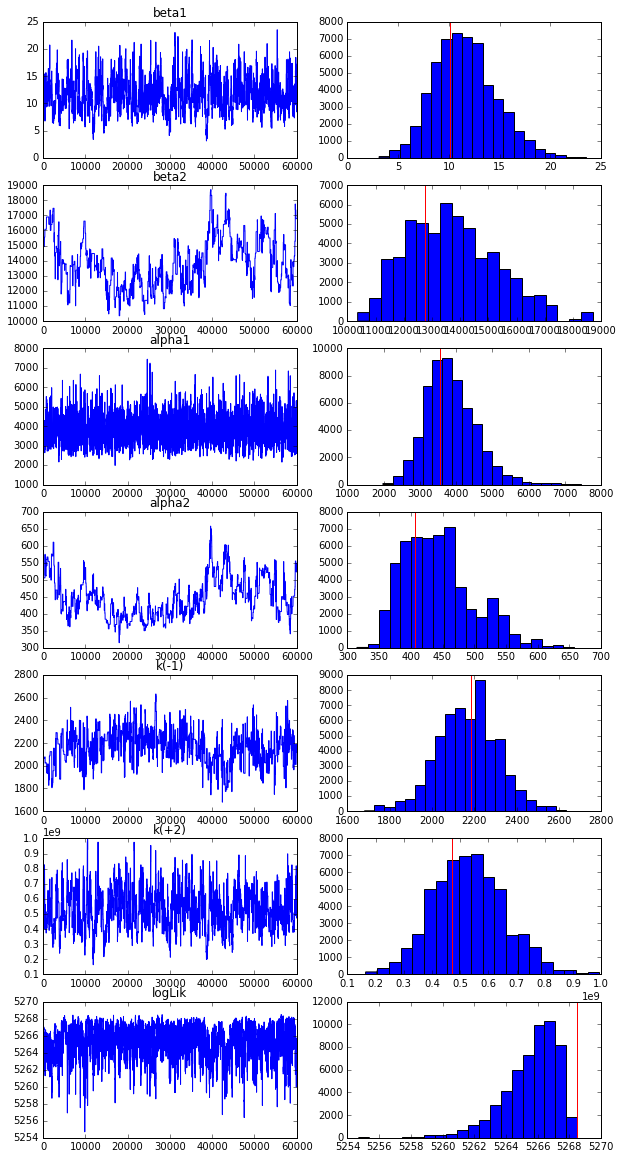

In [20]:
import display
display.quick_display1(preS, 5000, theta_names)

### Run adaptive sampler

In [21]:
proposer = RWMHProposal(dcprogslik, ([likelihood], mec, [conc]), verbose=True)
theta1 = pre_Xmax[:-1]
props = np.zeros((2*len(theta1), len(theta1)))
for i in range(2*len(theta1)):
    alpha, theta_p, Lp = proposer.propose_mixture(theta1, preLmax, True, np.identity(len(theta)))
    props[i] = theta_p

In [23]:
sampler = RosenthalAdaptiveSampler(samples_draw=10000, notify_every=1000, 
                     burnin_fraction=0.5, burnin_lag=50,
                     model=dcprogslik, data=([likelihood], mec, [conc]), 
                     proposal=proposer.propose_mixture,
                     verbose=True) 

Sampler initialised...


In [24]:
start = time.clock()
S = sampler.sample(theta1)
t = time.clock() - start
print ('\nCPU time in sampler =', t)

10.0 %
Acceptance: 0.000000000; Scale factor decreased to 0.900000000 at iteration 50
Acceptance: 0.860000000; Scale factor increased to 0.990000000 at iteration 100
Acceptance: 0.560000000; Scale factor increased to 1.089000000 at iteration 150
Acceptance: 0.680000000; Scale factor increased to 1.197900000 at iteration 200
Acceptance: 0.600000000; Scale factor increased to 1.317690000 at iteration 400
Acceptance: 0.080000000; Scale factor decreased to 1.185921000 at iteration 550
Acceptance: 0.080000000; Scale factor decreased to 1.067328900 at iteration 600
Acceptance: 0.020000000; Scale factor decreased to 0.960596010 at iteration 650
Acceptance: 0.080000000; Scale factor decreased to 0.864536409 at iteration 750
20.0 %
Acceptance: 0.080000000; Scale factor decreased to 0.778082768 at iteration 1050
Acceptance: 0.040000000; Scale factor decreased to 0.700274491 at iteration 1150
Acceptance: 0.080000000; Scale factor decreased to 0.630247042 at iteration 1300
Acceptance: 0.080000000;

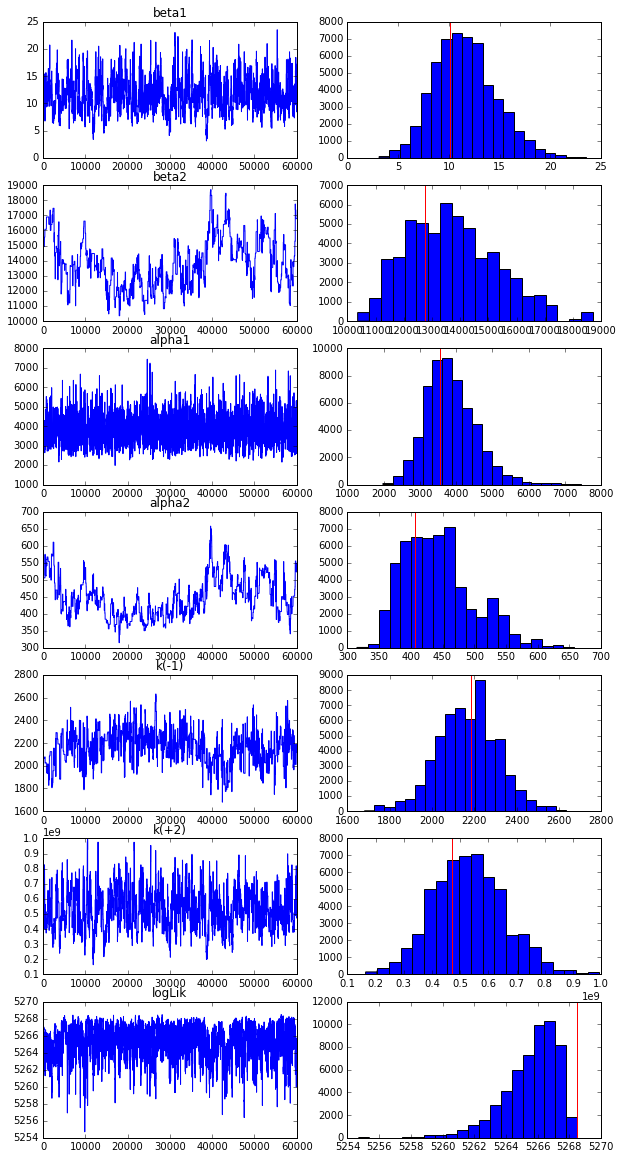

In [25]:
display.quick_display1(preS, 5000, theta_names)

In [26]:
Lmax = S[-1].max()
print('preLmax = ', preLmax, 'Lmax = ', Lmax)
imax = np.where(S[-1] == S[-1].max())[0][0]
print('imax = ', imax)
Xmax = S[:, imax]
print('Xmax', Xmax)

preLmax =  5268.49962471 Lmax =  5268.52684469
imax =  220
Xmax [  1.00359159e+01   1.27324903e+04   3.62233651e+03   4.11897530e+02
   2.18095725e+03   4.72635428e+08   5.26852684e+03]


In [27]:
#np.savetxt('AChR_MCMC_adaptive_1M.csv', S, delimiter=',')